In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras
from sklearn.metrics import confusion_matrix,accuracy_score
import warnings
warnings.filterwarnings('ignore')

# set standard color variable
color = "#1f77b4"


### Load data and check basic information

In [8]:
path = '/content/archivetempenergy_data_set.csv'

# Load data into a DataFrame and check its shape
data = pd.read_csv(path)
data.shape

(19735, 29)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

### Check for missing values

In [10]:
# Check for missing values
data.isnull().sum()

,0
date,0
Appliances,0
lights,0
T1,0
RH_1,0
T2,0
RH_2,0
T3,0
RH_3,0
T4,0


### Check for duplicate *data*

In [11]:
any(data.duplicated())

False

In [12]:
# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M', errors='coerce')

### Identify Outliers


In [13]:
# Calculate Z-scores for numeric columns
z_scores = np.abs(zscore(data.select_dtypes(include=[np.number])))

# Set threshold for outliers
threshold = 3

# Identify outliers
outliers = (z_scores > threshold)

# Create DataFrame to track outliers and display them
outliers_df = pd.DataFrame(outliers, columns=data.select_dtypes(include=[np.number]).columns)
outlier_rows = data[outliers_df.any(axis=1)]
print(f"Outlier rows:\n{outlier_rows}")


Outlier rows:
                     date  Appliances  lights         T1       RH_1  \
0     2016-01-11 17:00:00          60      30  19.890000  47.596667   
1     2016-01-11 17:10:00          60      30  19.890000  46.693333   
2     2016-01-11 17:20:00          50      30  19.890000  46.300000   
3     2016-01-11 17:30:00          50      40  19.890000  46.066667   
4     2016-01-11 17:40:00          60      40  19.890000  46.333333   
...                   ...         ...     ...        ...        ...   
19724 2016-05-27 16:20:00         100       0  25.500000  45.933333   
19725 2016-05-27 16:30:00         220       0  25.426667  46.060000   
19726 2016-05-27 16:40:00         180       0  25.500000  46.530000   
19733 2016-05-27 17:50:00         420      10  25.500000  46.990000   
19734 2016-05-27 18:00:00         430      10  25.500000  46.600000   

              T2       RH_2         T3       RH_3         T4  ...         T9  \
0      19.200000  44.790000  19.790000  44.730000  19

#### Impute outliers using median

In [14]:
# Exclude the 'date' column from imputation
imputer = SimpleImputer(strategy='median')

# Select only numerical features for imputation
numerical_features = data.select_dtypes(include=[np.number])

data_imputed_numerical = imputer.fit_transform(numerical_features)
data_imputed_numerical = pd.DataFrame(data_imputed_numerical, columns=numerical_features.columns)

# Concatenate the imputed numerical features with the original 'date' column
data_imputed = pd.concat([data['date'], data_imputed_numerical], axis=1)

print(f"Imputed data shape: {data_imputed.shape}")

print(data_imputed)

Imputed data shape: (19735, 29)
                     date  Appliances  lights         T1       RH_1  \
0     2016-01-11 17:00:00        60.0    30.0  19.890000  47.596667   
1     2016-01-11 17:10:00        60.0    30.0  19.890000  46.693333   
2     2016-01-11 17:20:00        50.0    30.0  19.890000  46.300000   
3     2016-01-11 17:30:00        50.0    40.0  19.890000  46.066667   
4     2016-01-11 17:40:00        60.0    40.0  19.890000  46.333333   
...                   ...         ...     ...        ...        ...   
19730 2016-05-27 17:20:00       100.0     0.0  25.566667  46.560000   
19731 2016-05-27 17:30:00        90.0     0.0  25.500000  46.500000   
19732 2016-05-27 17:40:00       270.0    10.0  25.500000  46.596667   
19733 2016-05-27 17:50:00       420.0    10.0  25.500000  46.990000   
19734 2016-05-27 18:00:00       430.0    10.0  25.500000  46.600000   

              T2       RH_2         T3       RH_3         T4  ...         T9  \
0      19.200000  44.790000  19.790

# Exploratory Data Analysis

In [15]:
# Copy dataset for time-based analysis
new_data = data_imputed.copy()
new_data

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60.0,30.0,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.5300,6.60,733.5,92.000000,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60.0,30.0,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.5600,6.48,733.6,92.000000,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.5000,6.37,733.7,92.000000,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.25,733.8,92.000000,6.000000,51.500000,5.0,45.410390,45.410390
4,2016-01-11 17:40:00,60.0,40.0,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.13,733.9,92.000000,5.666667,47.666667,4.9,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,23.200000,46.7900,22.70,755.2,55.666667,3.333333,23.666667,13.3,43.096812,43.096812
19731,2016-05-27 17:30:00,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,23.200000,46.7900,22.60,755.2,56.000000,3.500000,24.500000,13.3,49.282940,49.282940
19732,2016-05-27 17:40:00,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,23.200000,46.7900,22.50,755.2,56.333333,3.666667,25.333333,13.3,29.199117,29.199117
19733,2016-05-27 17:50:00,420.0,10.0,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,23.200000,46.8175,22.30,755.2,56.666667,3.833333,26.166667,13.2,6.322784,6.322784


### Add Features such as time, hour, month and day of the week

In [16]:
# Converting date into datetime
new_data['date'] = new_data['date'].astype('datetime64[ns]')
new_data['Date'] = pd.to_datetime(new_data['date']).dt.date
new_data['Time'] = pd.to_datetime(new_data['date']).dt.time
new_data['hour'] = new_data['date'].dt.hour
new_data['month'] = new_data['date'].dt.month
new_data['day_of_week'] = new_data['date'].dt.dayofweek

new_data= new_data.drop(["date"], axis=1)
new_data

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Windspeed,Visibility,Tdewpoint,rv1,rv2,Date,Time,hour,month,day_of_week
0,60.0,30.0,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,7.000000,63.000000,5.3,13.275433,13.275433,2016-01-11,17:00:00,17,1,0
1,60.0,30.0,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,6.666667,59.166667,5.2,18.606195,18.606195,2016-01-11,17:10:00,17,1,0
2,50.0,30.0,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,6.333333,55.333333,5.1,28.642668,28.642668,2016-01-11,17:20:00,17,1,0
3,50.0,40.0,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,6.000000,51.500000,5.0,45.410390,45.410390,2016-01-11,17:30:00,17,1,0
4,60.0,40.0,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,5.666667,47.666667,4.9,10.084097,10.084097,2016-01-11,17:40:00,17,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,3.333333,23.666667,13.3,43.096812,43.096812,2016-05-27,17:20:00,17,5,4
19731,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,3.500000,24.500000,13.3,49.282940,49.282940,2016-05-27,17:30:00,17,5,4
19732,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,3.666667,25.333333,13.3,29.199117,29.199117,2016-05-27,17:40:00,17,5,4
19733,420.0,10.0,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,3.833333,26.166667,13.2,6.322784,6.322784,2016-05-27,17:50:00,17,5,4


### Calculate and Display hourly energy consumption

In [17]:
# Calculate the total energy consumed by the appliance per hour
app_hour = new_data.groupby(by='hour',as_index=False)['Appliances'].sum()
# Sort app_hour by descending order
app_hour.sort_values(by='Appliances',ascending=False)

,hour,Appliances
18,18,156670.0
17,17,133600.0
19,19,117600.0
11,11,109430.0
20,20,104380.0
10,10,103060.0
13,13,102540.0
12,12,101630.0
16,16,98560.0
9,9,92710.0


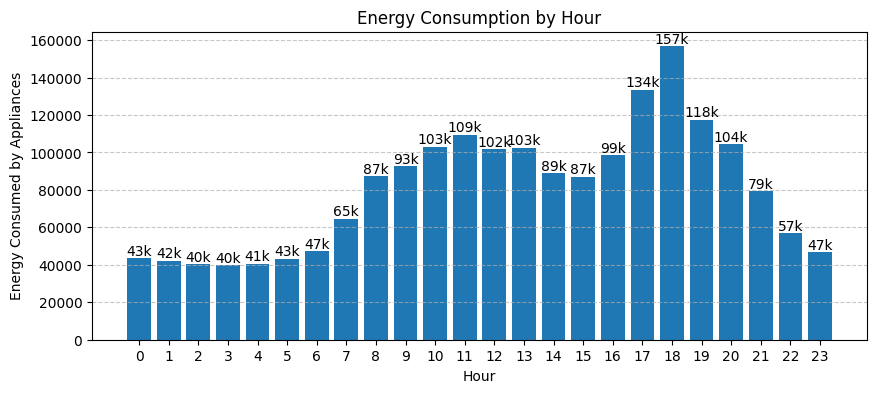

In [18]:
# Function to format the numerical value to 'k' format
def format_value(value):
    """
    Format numerical value to 'K'
    """
    if value < 1000:
        return f"{value:.0f}"
    elif value < 10000:
        return f"{value/1000:.1f}k"
    else:
        return f"{value/1000:.0f}k"

# Plotting the data
plt.figure(figsize=(10, 4))  # Set the figure size
bars = plt.bar(app_hour['hour'], app_hour['Appliances'], color=color)

# Add numerical values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, format_value(height), ha='center', va='bottom')

plt.xlabel('Hour')
plt.ylabel('Energy Consumed by Appliances')
plt.title('Energy Consumption by Hour')
plt.xticks(app_hour['hour'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [19]:
# Calculate the total energy consumed by the appliance per hour
app_week_day = new_data.groupby(by='day_of_week',as_index=False)['Appliances'].sum()
# Sort app_hour by descending order
app_week_day.sort_values(by='Appliances',ascending=False)

,day_of_week,Appliances
0,0,309610.0
4,4,297650.0
5,5,290690.0
3,3,260450.0
6,6,259690.0
2,2,259000.0
1,1,250920.0


### Energy consumption based on the day of the week

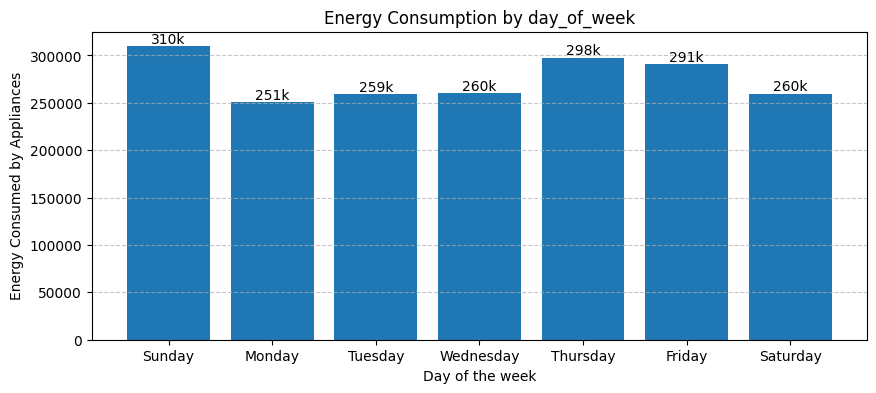

In [20]:
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 0: 'Sunday'}

# Plotting the data
plt.figure(figsize=(10, 4))  # Set the figure size
bars = plt.bar(app_week_day['day_of_week'], app_week_day['Appliances'], color=color)

# Add numerical values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, format_value(height), ha='center', va='bottom')

plt.xlabel('Day of the week')
plt.ylabel('Energy Consumed by Appliances')
plt.title('Energy Consumption by day_of_week')
plt.xticks(list(day_names.keys()), list(day_names.values()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Relationship between Date and Appliances

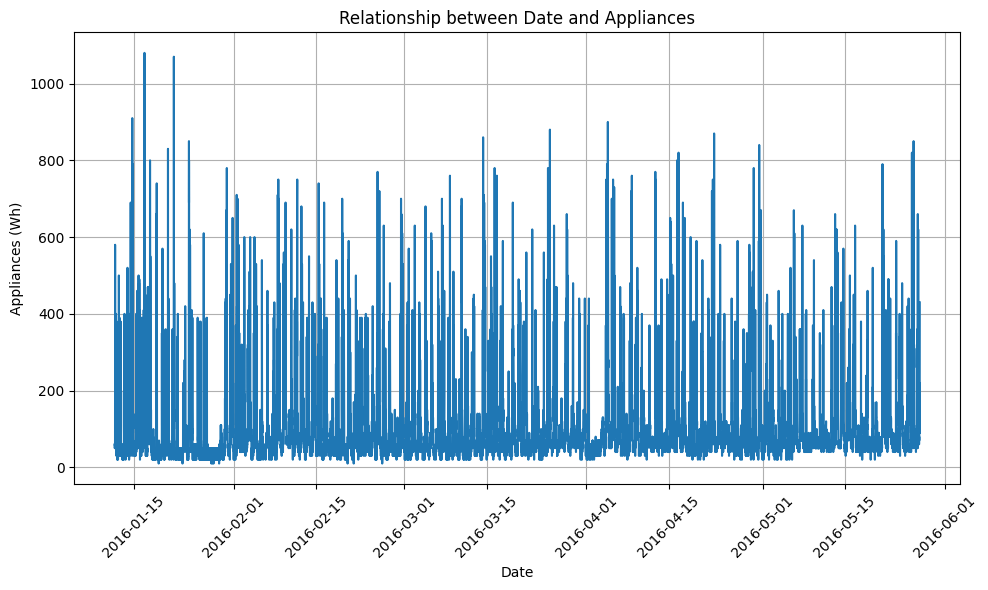

In [21]:
# Plot the relationship between 'date' and 'Appliances'
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['Appliances'], color='#1f77b4',  linestyle='-')
plt.title('Relationship between Date and Appliances')
plt.xlabel('Date')
plt.ylabel('Appliances (Wh)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

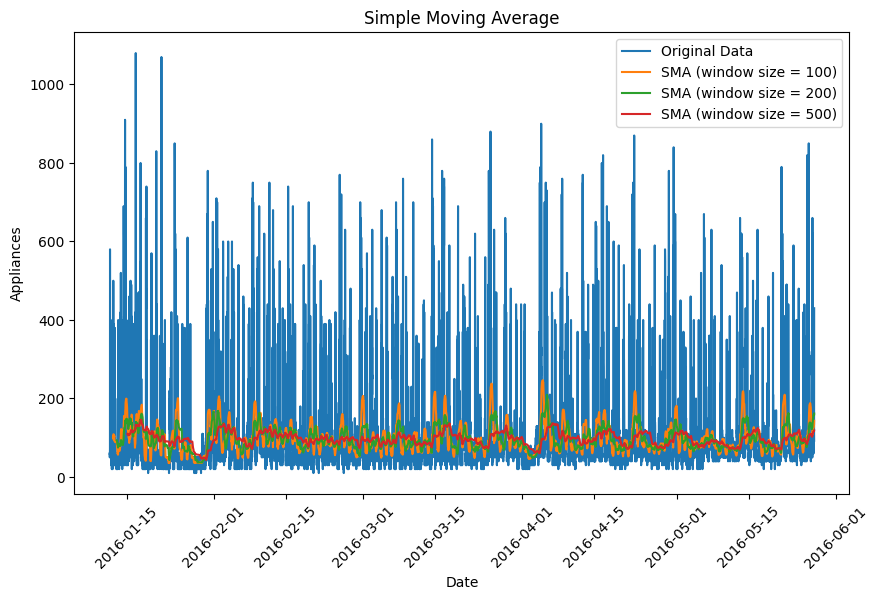

In [22]:
# Calculate the simple moving averages (SMA) of the 'Appliances' column in the data DataFrame using different window sizes
window_size_1 = 100
window_size_2 = 200
window_size_3 = 500
sma_1 = data['Appliances'].rolling(window=window_size_1).mean() # get the mean in the time span of 100 past data entries
sma_2 = data['Appliances'].rolling(window=window_size_2).mean() # get the mean in the time span of 200 past data entries
sma_3 = data['Appliances'].rolling(window=window_size_3).mean() # get the mean in the time span of 300 past data entries

# Draw the plot
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['Appliances'], label='Original Data')
plt.plot(data['date'], sma_1, label='SMA (window size = {})'.format(window_size_1))
plt.plot(data['date'], sma_2, label='SMA (window size = {})'.format(window_size_2))
plt.plot(data['date'], sma_3, label='SMA (window size = {})'.format(window_size_3))
plt.xlabel('Date')
plt.ylabel('Appliances')
plt.title('Simple Moving Average')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Visualize of Randomly Selected Weekly Data

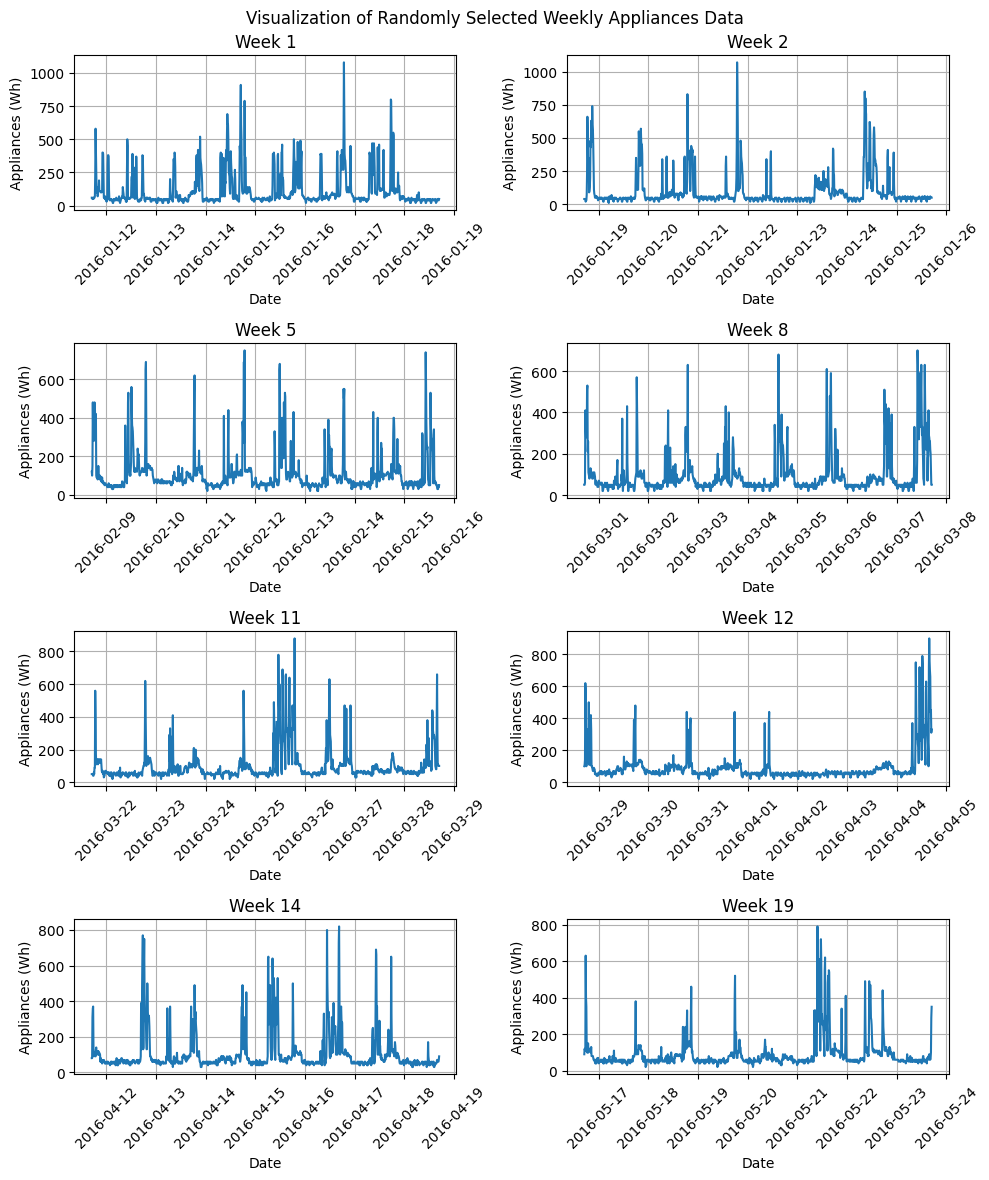

In [23]:
import random

len_weekly_data = 6*24*7 # 10 entries per minute => 6 times per hour => * 24 h * 7 days

# Function to randomly select 8 different weeks from the entire time range
def select_random_weeks(data):
    """
    Randomly select different week from the data
    """
    num_weeks = len(data) // len_weekly_data
    random_week_indices = random.sample(range(num_weeks), 8)
    random_week_indices.sort()
    return random_week_indices

# Randomly select 8 different weeks
random_week_indices = select_random_weeks(data)

# Create subplots arranged in a 4x2 grid
fig, axs = plt.subplots(4, 2, figsize=(10, 12))
fig.suptitle('Visualization of Randomly Selected Weekly Appliances Data')

# Plotting each randomly selected week's data
for i in range(4):
    for j in range(2):
        start_index = random_week_indices[i * 2 + j] * len_weekly_data
        end_index = start_index + len_weekly_data

        # Filter data for the randomly selected week
        week_data = data.iloc[start_index:end_index]

        # Plot the relationship between 'date' and 'Appliances' for the randomly selected week
        axs[i, j].plot(week_data['date'], week_data['Appliances'], color='#1f77b4', linestyle='-')
        axs[i, j].set_title(f'Week {random_week_indices[i * 2 + j] + 1}')
        axs[i, j].set_xlabel('Date')
        axs[i, j].set_ylabel('Appliances (Wh)')
        axs[i, j].tick_params(axis='x', rotation=45)
        axs[i, j].grid(True)

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()
plt.show()


# Feature engineering

## Correlation analysis

In [24]:
# Delete  irrelavant columns
new_data = new_data.drop(['Date', 'Time', 'rv1', 'rv2'], axis=1)

# Check if there is any format that is not 'float64' or 'int64'
for column in new_data.columns:
    if new_data[column].dtype != 'float64' and new_data[column].dtype != 'int64':
        print(f"Column '{column}' has non-numeric data type: {new_data[column].dtype}")

Column 'hour' has non-numeric data type: int32
Column 'month' has non-numeric data type: int32
Column 'day_of_week' has non-numeric data type: int32


In [25]:
# Change the format tp 'float64'

new_data['hour'] = new_data['hour'].astype(float)
new_data['month'] = new_data['month'].astype(float)
new_data['day_of_week'] = new_data['day_of_week'].astype(float)

# Check type again.
print(new_data.dtypes)

Appliances     float64
lights         float64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
hour           float64
month          float64
day_of_week    float64
dtype: object


### Feature Correlations Heatmap for all features.

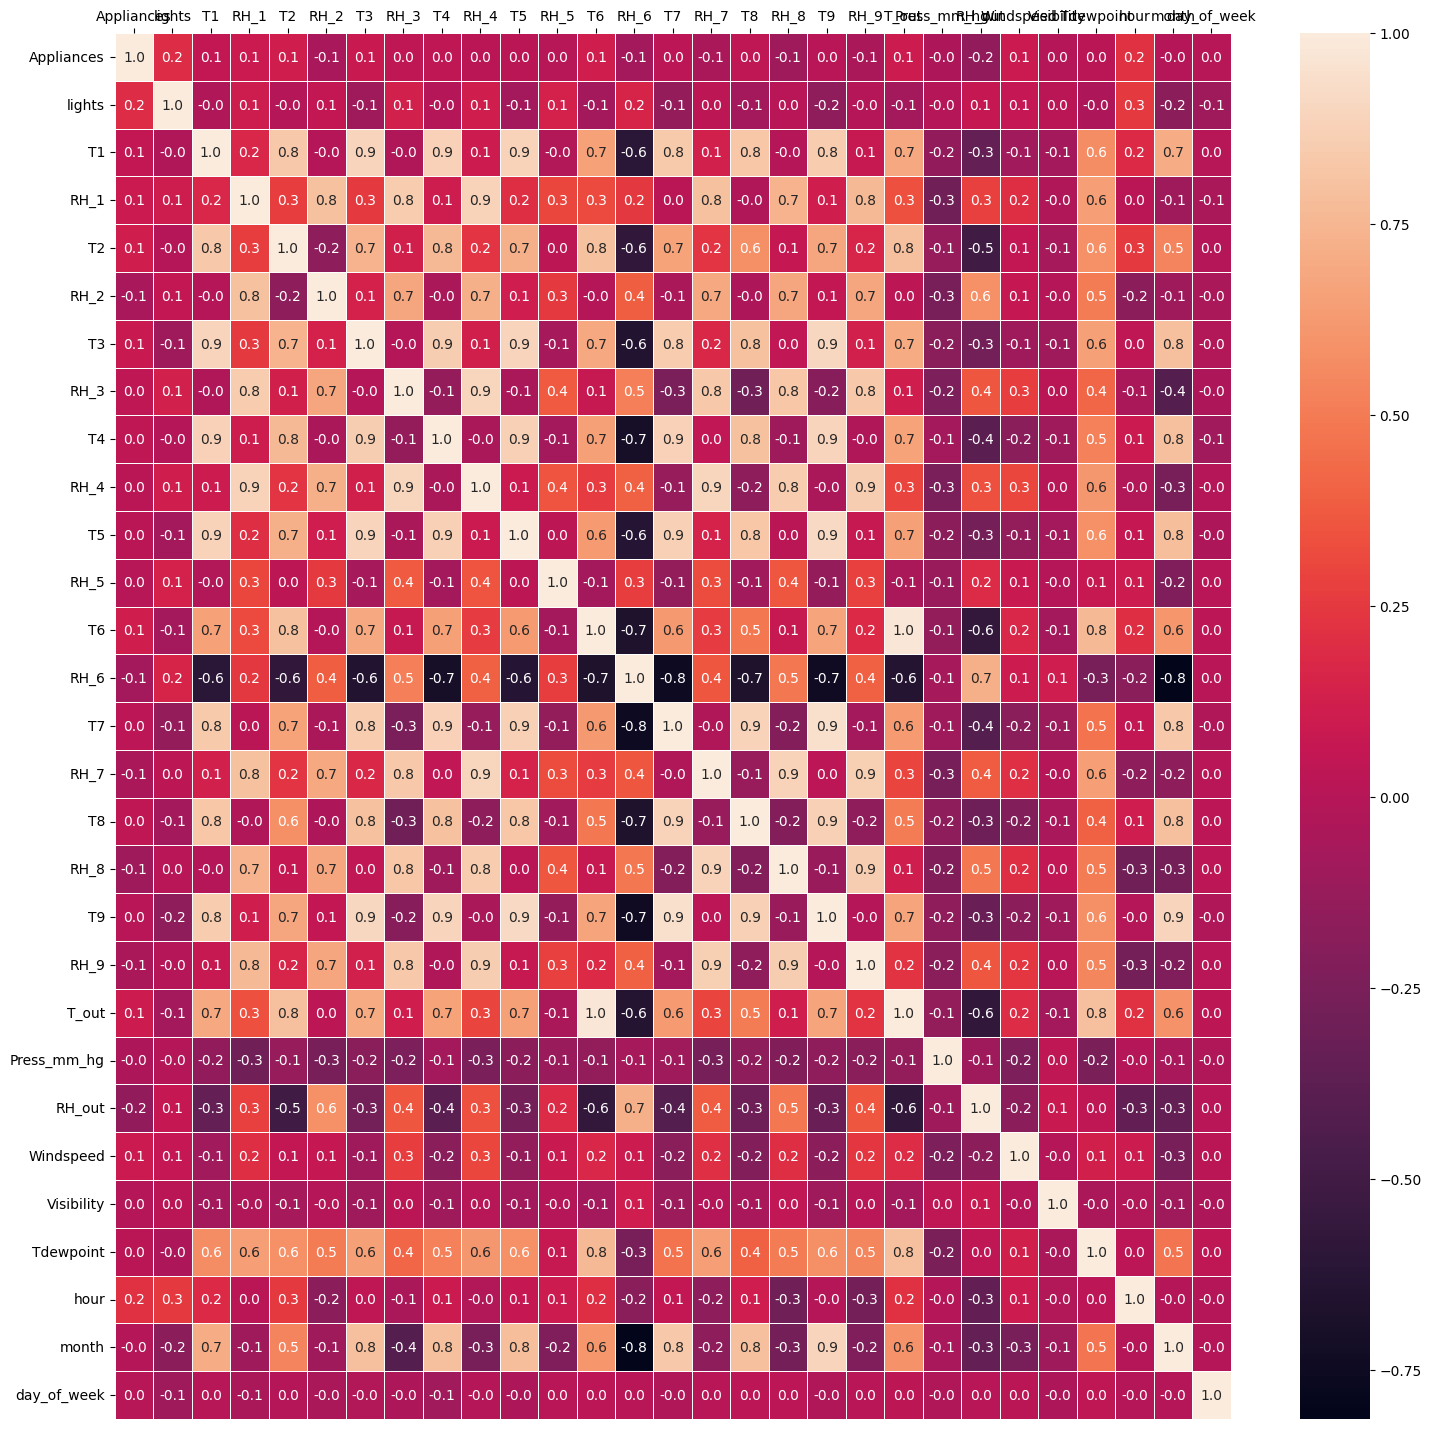

In [26]:
# Plot a heatmap of correlations
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(new_data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
ax.xaxis.set_ticks_position('top')


### Dropping highly correlated features to reduce the dimension.

<Axes: >

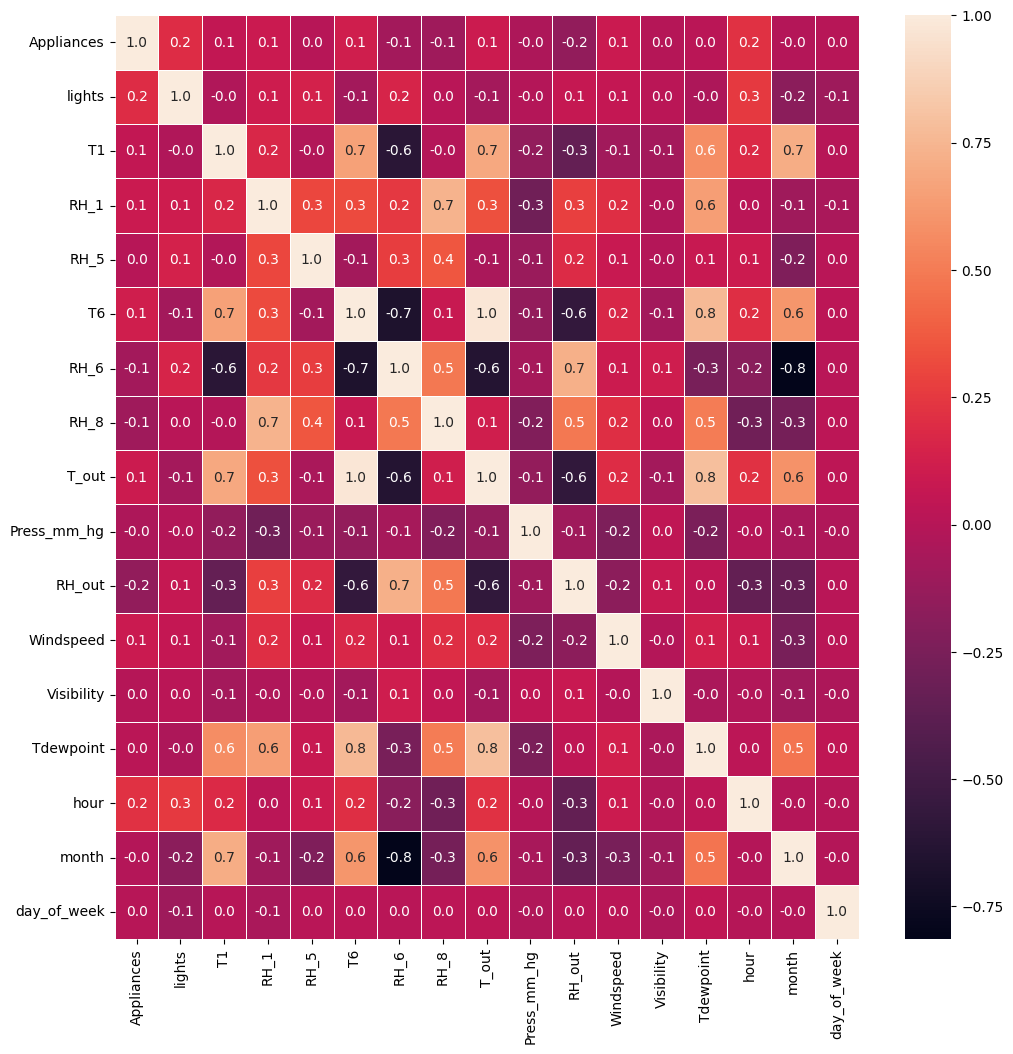

In [27]:
# Drop less relevant features from 'new_data'
features_to_drop = ['T2', 'T3', 'T4', 'T5', 'T7', 'T8', 'T9', 'RH_2', 'RH_3', 'RH_4', 'RH_7', 'RH_9']
filtered_data = new_data.drop(features_to_drop, axis=1)


# Plot correlation heatmap for 'filtered_data'
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(filtered_data.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)

###Implementing Recursive Feature Elimination to eliminate further features.

In [ ]:
# Split data into features (X) and target (y)
X = filtered_data.iloc[:, 1:]
y = data["Appliances"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Perform feature selection using RFECV with RandomForestRegressor
clf_rf = RandomForestRegressor()
rfecv = RFECV(estimator=clf_rf, step=1, cv=5, scoring='neg_mean_squared_error')
rfecv = rfecv.fit(x_train, y_train)

# Print optimal number of features and selected features
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])


Optimal number of features : 13
Best features : Index(['T1', 'RH_1', 'RH_5', 'T6', 'RH_6', 'RH_8', 'T_out', 'Press_mm_hg',
       'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'hour'],
      dtype='object')


### Extract features from data

In [28]:
training_data = data_imputed.copy()

# Converting date into datetime
training_data['date'] = training_data['date'].astype('datetime64[ns]')
training_data['Date'] = pd.to_datetime(training_data['date']).dt.date
training_data['Time'] = pd.to_datetime(training_data['date']).dt.time
training_data['hour'] = training_data['date'].dt.hour
training_data['month'] = training_data['date'].dt.month
training_data['day_of_week'] = training_data['date'].dt.dayofweek

training_data

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Windspeed,Visibility,Tdewpoint,rv1,rv2,Date,Time,hour,month,day_of_week
0,2016-01-11 17:00:00,60.0,30.0,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,7.000000,63.000000,5.3,13.275433,13.275433,2016-01-11,17:00:00,17,1,0
1,2016-01-11 17:10:00,60.0,30.0,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,6.666667,59.166667,5.2,18.606195,18.606195,2016-01-11,17:10:00,17,1,0
2,2016-01-11 17:20:00,50.0,30.0,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,6.333333,55.333333,5.1,28.642668,28.642668,2016-01-11,17:20:00,17,1,0
3,2016-01-11 17:30:00,50.0,40.0,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,6.000000,51.500000,5.0,45.410390,45.410390,2016-01-11,17:30:00,17,1,0
4,2016-01-11 17:40:00,60.0,40.0,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,5.666667,47.666667,4.9,10.084097,10.084097,2016-01-11,17:40:00,17,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,3.333333,23.666667,13.3,43.096812,43.096812,2016-05-27,17:20:00,17,5,4
19731,2016-05-27 17:30:00,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,3.500000,24.500000,13.3,49.282940,49.282940,2016-05-27,17:30:00,17,5,4
19732,2016-05-27 17:40:00,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,3.666667,25.333333,13.3,29.199117,29.199117,2016-05-27,17:40:00,17,5,4
19733,2016-05-27 17:50:00,420.0,10.0,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,3.833333,26.166667,13.2,6.322784,6.322784,2016-05-27,17:50:00,17,5,4


### Eliminate features

In [29]:
training_data= training_data[['date','Appliances','T1', 'RH_1', 'RH_5', 'T6', 'RH_6', 'RH_8', 'T_out', 'Press_mm_hg',
       'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'hour']]

training_data

,date,Appliances,T1,RH_1,RH_5,T6,RH_6,RH_8,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,hour
0,2016-01-11 17:00:00,60.0,19.890000,47.596667,55.200000,7.026667,84.256667,48.900000,6.60,733.5,92.000000,7.000000,63.000000,5.3,17
1,2016-01-11 17:10:00,60.0,19.890000,46.693333,55.200000,6.833333,84.063333,48.863333,6.48,733.6,92.000000,6.666667,59.166667,5.2,17
2,2016-01-11 17:20:00,50.0,19.890000,46.300000,55.090000,6.560000,83.156667,48.730000,6.37,733.7,92.000000,6.333333,55.333333,5.1,17
3,2016-01-11 17:30:00,50.0,19.890000,46.066667,55.090000,6.433333,83.423333,48.590000,6.25,733.8,92.000000,6.000000,51.500000,5.0,17
4,2016-01-11 17:40:00,60.0,19.890000,46.333333,55.090000,6.366667,84.893333,48.590000,6.13,733.9,92.000000,5.666667,47.666667,4.9,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100.0,25.566667,46.560000,52.400000,24.796667,1.000000,50.074000,22.70,755.2,55.666667,3.333333,23.666667,13.3,17
19731,2016-05-27 17:30:00,90.0,25.500000,46.500000,52.326667,24.196667,1.000000,49.790000,22.60,755.2,56.000000,3.500000,24.500000,13.3,17
19732,2016-05-27 17:40:00,270.0,25.500000,46.596667,52.266667,23.626667,1.000000,49.660000,22.50,755.2,56.333333,3.666667,25.333333,13.3,17
19733,2016-05-27 17:50:00,420.0,25.500000,46.990000,52.200000,22.433333,1.000000,49.518750,22.30,755.2,56.666667,3.833333,26.166667,13.2,17


### Implement Linear Regression to establish performance benchmarks.

In [30]:

data_lr = training_data.copy()

# Prepare x and y
X = data_lr.drop(['Appliances', 'date'], axis=1)
y = data_lr['Appliances']

# Calculate split point (last 30 days of data)
rows_per_day = 24 * 60 // 10  # 144 observations per day
test_size = 30 * rows_per_day

# Split the data
X_train = X.iloc[:-test_size]
X_test = X.iloc[-test_size:]
y_train = y.iloc[:-test_size]
y_test = y.iloc[-test_size:]

# Initialize and train the Linear Regression model
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

# Make predictions
train_predictions = lr_model.predict(X_train)
test_predictions = lr_model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Training RMSE: 100.0236
Test RMSE: 88.5936
Training MAE: 56.8414
Test MAE: 53.1308


### Create Lagged Features and Apply Min-Max Scaling

In [31]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Create lagged features for supervised learning.
    """
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Create lagged input sequences (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    # Create forecast sequences (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [f'var{j+1}(t+{i})' if i > 0 else f'var{j+1}(t)' for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)

    return agg


# Extract datetime and hour features separately
datetime_col = training_data['date']
hour_col = training_data['hour']

# Remove 'date' and 'hour' columns before scaling
data_for_scaling = training_data.drop(columns=['date', 'hour'])

# Convert data to numpy array and scale it
values = data_for_scaling.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Convert to supervised learning format
n_in, n_out = 1, 1
training_data = series_to_supervised(scaled, n_in, n_out)

# Drop unnecessary forecast columns
training_data.drop(training_data.columns[11:20], axis=1, inplace=True)

# Display the first few rows
print(training_data.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.046729   0.327349   0.566187   0.381691   0.381070   0.841827   
2   0.046729   0.327349   0.541326   0.381691   0.375443   0.839872   
3   0.037383   0.327349   0.530502   0.380037   0.367487   0.830704   
4   0.037383   0.327349   0.524080   0.380037   0.363800   0.833401   
5   0.046729   0.327349   0.531419   0.380037   0.361859   0.848264   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)   var8(t)  \
1   0.661412   0.372990   0.097675    0.894737    0.500000  0.369132   
2   0.660155   0.369132   0.100000    0.894737    0.476190  0.365595   
3   0.655586   0.365595   0.102327    0.894737    0.452381  0.361736   
4   0.650788   0.361736   0.104652    0.894737    0.428571  0.357878   
5   0.650788   0.357878   0.106977    0.894737    0.404762  0.354341   

    var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  
1  0.100000  0.894737  0.476190  0.894872  0.533937  
2  0.102327  0.894737  0.452381 

### Create train and test datasets

In [32]:
# Calculate the number of rows per day with 10-minute intervals
rows_per_day = 24 * 60 // 10

# Set the test size to 30 days worth of observations
test_size = 30 * rows_per_day


train_raw = training_data.iloc[:-test_size]
test_raw = training_data.iloc[-test_size:]

print(train_raw.shape, test_raw.shape)


# Reshape input to be 3D [samples, timesteps, features]
time_steps = 1
num_features = train_raw.shape[1]

train = train_raw.values.reshape(train_raw.shape[0], time_steps, num_features)
test = test_raw.values.reshape(test_raw.shape[0], time_steps, num_features)

print(train.shape, test.shape)


(15414, 17) (4320, 17)
(15414, 1, 17) (4320, 1, 17)


# LSTM Model

## Implement LSTM Model

In [72]:
# Model Configuration
time_steps = 1
num_features = 17

# Define the LSTM model
model = keras.Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(time_steps, num_features)))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False))  # Removed one LSTM layer
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                       │ (None, 1, 64)               │          20,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

## Model training and evaluation

In [73]:
# Train the model
history = model.fit(train, train_raw.values, epochs=10, batch_size=32, validation_data=(test, test_raw.values))

# Evaluate the model on the training data
train_loss, train_mae, train_rmse = model.evaluate(train, train_raw.values)
print(f"Train Loss: {train_loss}, Train MAE: {train_mae}, Train RMSE: {train_rmse}")

# Evaluate the model on the test data
test_loss, test_mae, test_rmse = model.evaluate(test, test_raw.values)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

# Make predictions
predictions = model.predict(test)


Epoch 1/10
482/482 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - RootMeanSquaredError: 0.2773 - loss: 0.0790 - mae: 0.2228 - val_RootMeanSquaredError: 0.2462 - val_loss: 0.0606 - val_mae: 0.2062
Epoch 2/10
482/482 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - RootMeanSquaredError: 0.2368 - loss: 0.0561 - mae: 0.1919 - val_RootMeanSquaredError: 0.2454 - val_loss: 0.0602 - val_mae: 0.2046
Epoch 3/10
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - RootMeanSquaredError: 0.2357 - loss: 0.0555 - mae: 0.1912 - val_RootMeanSquaredError: 0.2456 - val_loss: 0.0603 - val_mae: 0.2044
Epoch 4/10
482/482 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - RootMeanSquaredError: 0.2352 - loss: 0.0553 - mae: 0.1906 - val_RootMeanSquaredError: 0.2454 - val_loss: 0.0602 - val_mae: 0.2042
Epoch 5/10
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - RootMeanSquaredError: 0.2346 - loss: 0.0550 - mae: 0.1902 - val_RootMeanSquaredError: 0.2452 - val_loss: 0.0601 - val_mae: 0.2039
Epoch 6/10
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - RootMeanSquaredError: 0.23

## Visualize predictions

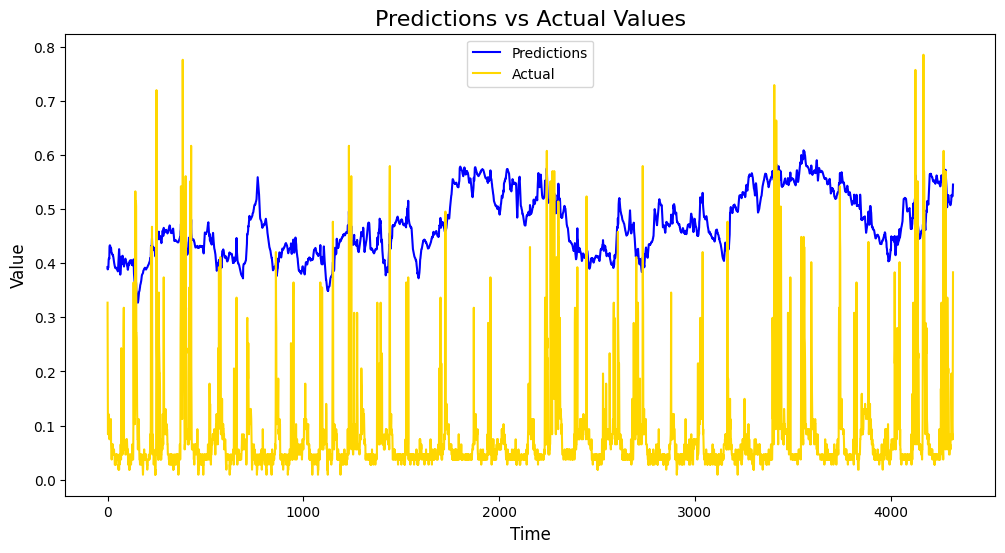

In [74]:
# Convert predictions and actual values to a 1D array
predictions_flat = predictions.flatten()
actual_values_flat = test_raw.iloc[:, 0].values.flatten()


data = pd.DataFrame({
    'Predictions': predictions_flat,
    'Actual': actual_values_flat
})

# Plot actual values and predictions
plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index, y=data['Predictions'], color="blue", label="Predictions")
sns.lineplot(x=data.index, y=data['Actual'], color="gold", label="Actual")

plt.title('Predictions vs Actual Values', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.show()

